<a href="https://colab.research.google.com/github/hakim-code/arduino_sketches/blob/master/Time_Series_Forecasting_via_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Theory on Vision Transformer
###Neural networkm architecture for image classification task.ViT is used to capture the relationship between different image region(patch). It can do both computer vision and text processing or even both combined.
###i. Patch Embedding:
###input image is patched into fixed size region(16x16)
###Each patch is linearly formed into sequence that is flattened into an image vector(some call it as patch token). Because vectors are the form that transformer work with. Then it will be positional enbedded. These are sent to FFN self attention multi layer
###ii. Positional Encoding
####Since ViT does not inherent positional information like CNN, positional encodings are addedto preserve spatial information
###iii. Linear Projection- create image vector
####Once the patch is embedded it will obtain a token of embedding, which is used as input to the
####transformer encoder(transformer encode the vector to guess which object is that)
###iv. Transformer Encoder:
####it consists of feed forward network and self attention mechanism. These will be assessed via cross entropy loss to determine what object is that
###v. Classification Head
####Output embedding token from the final trnsformer layer is used for classification task
####Classification head is added to predict class label
###vi. Training
#### ViT is trained with labeled
####upscaling the image: images are converted into patch token
#### Regularization in ViT: image Vector is regularized with squared regularizer to preserve the norm of the image vector, if not the norm vector is too different between the upscaled images and the original one which causes training transformer  not to recognize the relationship between the dataset, which during training and during fine tuning



###CNN focusses on local view.The pattern can be predicted on less amount of data compared to ViT.Because at CNN we teach model not how to focus but what to focus.

###Since CNN already know what to look patch by patch


###LSTM knows how to handle sequences from left to right
###


##DEiT
##Data augmentation
##Manipulation of image parameter(saturation, brightness, strach out, zoom in-out)

##Optimization
##optimizer, learning rate, weight decay,computation power

##regularization to fine tune the resolution of images for training-> upscaling
###changing the image pixel: 224x224 -> 384x384


#How to describe if a machine learning model good or not ?
##1.Parameter: how many weight and biases are used during the learning tells the different learnable elements that cause the adjustments in learning model make the prediction during training
##2. Floating Points (FLOPs):represent the number of floating-point operations performed by the model during inference. It's a measure of computational complexity and gives an idea of how much computational power is required for the model to make predictions.
##3. %-Top 1 dataset: refers to the model's accuracy on the ImageNet dataset. The "top-1" accuracy measures the percentage of test samples for which the correct label is the model's most confident prediction. In this case, the model achieved an accuracy of 81.8%, meaning it correctly predicted the top class for 81.8% of the images in the ImageNet dataset.


#Text
###representation of a sequence of characters or words. it can encoded into vectors. Transformer look them as a set.
###inside transformer block all sets are looked parallel
### for transformer to know which one comes first, these set are encoded into positional embeddings. So there are two positional embedding and a the patch token(vector)  
###initialization of vector can done with numbers or by token identifier
###it is up to the loss constrained neural network to figure out a better inner representation where words belonging together are shifted closer to each other.


#Neural network
###works with points that determined by coordinate. it can be strecthed. it can be encoded into vectors

#Images
##Grayscale image: is matrix of numbers
###High number means high light intensity in that region, low number is darker spot
##Color image: stack of RGB three matrices
###High number in red means darker red -> emits certain light frequency  

#1: Setup the environment:

##1.1: Google Colab setup

In [2]:
try:
  import google.colab
  COLAB = True
  print("Note: using Google Colab")
except:
  print("Note: Not using Google Colab")
  COLAB = False

Note: using Google Colab



##1.1: Pytorch setup

###determining which device to use for running PyTorch operations.

In [3]:
!pip install torch -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html


Looking in links: https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html


In [4]:
import torch
device = (#later we use device to run the transformer in pytorch, so cuda is gpu faster
    "mps"
    if getattr(torch, "has_mps", False)
    else "cuda"

    if torch.cuda.is_available()
    else "cpu"
)

print(f"Using device: {device}")

Using device: cuda


<ipython-input-4-f531b23a823c>:4: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  if getattr(torch, "has_mps", False)


In [5]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    # Get the current CUDA device
    device = torch.cuda.current_device()
    print(f'Using CUDA device: {torch.cuda.get_device_name(device)}')
else:
    print('CUDA is not available. Using CPU.')



Using CUDA device: Tesla T4


#2: Transformer Vision for TimeSeries in Pytorch

###The transformative landscape has pushed the boundaries of what's achievable in tasks like machine translation, language modeling and data analysis.

###The application is not only on textual data but also for time-series-predictions.

###In time-series prediction, the objective is to forecast the future values based on the past data. It is a sequence-to-sequence task, whereas the past data forms an input sequence in oreder to predict the future data which is the output sequence.

###We will build a transformer model firstly for NLP application to get the right foundational understanding before we jump into time-series-prediction application.


##2.1: NLP Example:

###2.1.1 Import the required packages
###Then Mount google drive and the dataset

####imports two classes, DataLoader and TensorDataset, from the torch.utils.data module. These classes are often used to manage and load data efficiently when working with PyTorch. DataLoader helps in creating batches of data for training, and TensorDataset is a dataset wrapper for PyTorch tensors.

####mports the StandardScaler class from the sklearn.preprocessing module. Scikit-Learn is a popular machine learning library in Python, and StandardScaler is used for standardizing or scaling data features to have mean 0 and standard deviation 1. It's a common preprocessing step before applying machine learning algorithms.

####imports the ReduceLROnPlateau class from the torch.optim.lr_scheduler module. In the context of deep learning, this class is used to implement learning rate schedulers that can reduce the learning rate during training if certain conditions (plateau in loss improvement) are met. It helps optimize the training process.

In [6]:
import numpy as np
import pandas as pd
import torch #use framework for dL neuralnetwork
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset#PyTorch data manager
from sklearn.preprocessing import StandardScaler #to scale data feature
from torch.optim.lr_scheduler import ReduceLROnPlateau #Reduce learning rate on plateau epoch not bring significant converg



#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#insert the list of column label into our csv dataset since the label of the columns are not available
column_names = ['year', 'month', 'day', 'dec_year', 'sn_value', 'sn_error', 'obs_num', 'unused_1']

#import the dataframe
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time-Series-Prediction_via_Transformer Vision /SN_d_tot_V2.0.csv')

In [8]:
df.head()#raw data has no head

,1818;01;01;1818.001; -1; -1.0; 0;1
0,1818;01;02;1818.004; -1; -1.0; 0;1
1,1818;01;03;1818.007; -1; -1.0; 0;1
2,1818;01;04;1818.010; -1; -1.0; 0;1
3,1818;01;05;1818.012; -1; -1.0; 0;1
4,1818;01;06;1818.015; -1; -1.0; 0;1


In [9]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Time-Series-Prediction_via_Transformer Vision /SN_d_tot_V2.0.csv',
  sep = ';', header=None, names = column_names,#separator is semicolon
  #Indicates that the CSV file doesn't have a header row, we provide one with header = 0#Specifies that
  #the string '-1' in the CSV file should be treated as NaN (missing values).
  na_values = ['-1'], index_col =False) #no row should be quantified index col = 0

In [10]:
df.head()#data should be presented with head title

,year,month,day,dec_year,sn_value,sn_error,obs_num,unused_1
0,1818,1,1,1818.001,-1,NaN,0,1
1,1818,1,2,1818.004,-1,NaN,0,1
2,1818,1,3,1818.007,-1,NaN,0,1
3,1818,1,4,1818.010,-1,NaN,0,1
4,1818,1,5,1818.012,-1,NaN,0,1


####'year': This column likely represents the year when the data was recorded. It tells you the specific year associated with each data entry.
####'month': This column probably represents the month when the data was recorded. It tells you the specific month associated with each data entry.
####'day': This column likely represents the day when the data was recorded. It tells you the specific day of the month associated with each data entry.

####'dec_year': This could represent the year in decimal form, which is a more precise way to represent years. It might be used for calculations that require more precision.
####'sn_value': This column probably contains the main data value or measurement, which might represent something related to sunspot activity or another scientific measurement.
####'sn_error': This column may contain the error or uncertainty associated with the 'sn_value.' It tells you how accurate or uncertain the measurement is.
####'obs_num': This column might represent the observation number, indicating the order in which observations were made.
####'unused1': This column seems to be included in the dataset but isn't currently used for any specific purpose. It might be empty or have no meaningful data.


###2.1.2: Data Preprocessing


1.    finding the maximum index (position) in the DataFrame
2.    creating a new DataFrame df by taking a slice of the original DataFrame df starting from the calculated start_id
3.  converting the 'sn_value' column in the DataFrame df to a numeric data type (specifically, float).
4. This ensures that the 'sn_value' column contains numerical values that can be used for calculations.
5. reshape the arrays to have a single column and as many rows as needed, effectively creating 2D arrays.
6. instance of the StandardScaler class from the scikit-learn library. The standard scaler is used for standardizing data, which means scaling it to have a mean of 0 and a standard deviation of 1.
7. After scaling, the data is flattened into a 1D array and then converted to a Python list.



In [11]:
#finding maximum index from the column obs_num,find one equals to 0,next one should be start_id
start_id = max(df[df['obs_num'] == 0].index.tolist()) +1
#
df = df[start_id: ].copy()#use copy()
#convert sn_value into numeric float datatype
df['sn_value'] = df['sn_value'].astype(float)

#split the dataset into train and test
df_train = df[df['year']<2000]
df_test = df[df['year']>=2000]

#reshape into column vector so that transformer can read
spots_train = df_train['sn_value'].to_numpy().reshape(-1,1)#convert them into column vector
spots_test = df_test['sn_value'].to_numpy().reshape(-1,1)

#scaling the data
scaler = StandardScaler()
spots_train = scaler.fit_transform(spots_train).flatten().tolist()
spots_test = scaler.fit_transform(spots_test).flatten().tolist()

#spots_test.head()

In [12]:
import numpy as np

arr_2d = np.array([[1, 2, 3], [4, 5, 6]])
arr_1d = arr_2d.flatten()
list_from_arr = arr_1d.tolist()

print(np.shape(arr_1d))#[1 2 3 4 5 6]


print(np.shape(list_from_arr))#[1, 2, 3, 4, 5, 6]




(6,)
(6,)


In [13]:
df.head(10)
#row which contains 0 dissappear

,year,month,day,dec_year,sn_value,sn_error,obs_num,unused_1
11314,1848,12,23,1848.977,353.0,23.8,1,1
11315,1848,12,24,1848.980,240.0,19.6,1,1
11316,1848,12,25,1848.982,275.0,21.0,1,1
11317,1848,12,26,1848.985,352.0,23.8,1,1
11318,1848,12,27,1848.988,268.0,20.8,1,1
11319,1848,12,28,1848.990,285.0,21.4,1,1
11320,1848,12,29,1848.993,343.0,23.5,1,1
11321,1848,12,30,1848.996,340.0,23.4,1,1
11322,1848,12,31,1848.999,238.0,19.6,1,1
11323,1849,1,1,1849.001,287.0,20.9,1,1


In [14]:
import numpy as np

# Assuming spots_train and spots_test are NumPy arrays

# Get the size (total number of elements) of spots_train and spots_test
size_train = np.size(spots_train)
size_test = np.size(spots_test)

# Get the dimensions (shape) of spots_train and spots_test
dimensions_train = np.shape(spots_train)
dimensions_test = np.shape(spots_test)

print(f"Size of spots_train: {size_train}")
print(f"Size of spots_test: {size_test}")

print(f"Dimensions of spots_train in a column vector: {dimensions_train}")
print(f"Dimensions of spots_test in a column vector: {dimensions_test}")


Size of spots_train: 55160
Size of spots_test: 8705
Dimensions of spots_train in a column vector: (55160,)
Dimensions of spots_test in a column vector: (8705,)


In [15]:
#break the data into sequences of patches
SEQUENCE_SIZE = 10
#Each sequence will contain 10 data points. we train 10 points to predict the 1h
#the 11-20 will predict the 2

#function to create sequence
def to_sequences(seq_size, obs):
  x =[] #init empty list
  y =[]
  for i in range(len(obs)- seq_size): #number of index - 10
    window = obs[i:(i+ seq_size)]
    after_window =obs[i + seq_size]
    x.append(window)#fill in the list
    y.append(after_window)

  return torch.tensor(x, dtype = torch.float32).view(-1, seq_size, 1),\
  torch.tensor(y, dtype= torch.float32).view(-1,1)

In [16]:
dataset_dummy = np.arange(0, 10).tolist()

def to_sequences(seq_size, obs):
  x =[] #init empty list
  y =[]
  for i in range(len(obs)- seq_size): #number of index - 10
    window = obs[i:(i+ seq_size)]
    after_window =obs[i + seq_size]
    x.append(window)#fill in the list
    y.append(after_window)
  return torch.tensor(x, dtype = torch.float32).view(-1, seq_size, 1),\
  torch.tensor(y, dtype= torch.float32).view(-1,1)

x_dataset_dummy, y_dataset_dummy = to_sequences(2, dataset_dummy)
# Print the resulting tensors
print("x_dataset_dummy:")
print(x_dataset_dummy)
print("\ny_dataset_dummy:")
print(y_dataset_dummy)


x_dataset_dummy:
tensor([[[0.],
         [1.]],

        [[1.],
         [2.]],

        [[2.],
         [3.]],

        [[3.],
         [4.]],

        [[4.],
         [5.]],

        [[5.],
         [6.]],

        [[6.],
         [7.]],

        [[7.],
         [8.]]])

y_dataset_dummy:
tensor([[2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])


The tensor x_dataset_dummy represents the input sequences (windows) for the model. It is a 3D tensor with dimensions (batch_size, seq_size, input_dim).See the example.

Each subsequence or window has a size of seq_size = 2.
The input dimension is set to 1 because each element in the window is a scalar.
The batch_size corresponds to the number of windows created from the original dataset, which is len(dataset_dummy) - seq_size = 8 in this case.



*   The tensor y_dataset_dummy represents the corresponding output elements (the element that comes after each window).
It is a 2D tensor with dimensions (batch_size, output_dim).
Each element in this tensor is a scalar, representing the value that the model is trained to predict.
* In summary, the dimensions are structured this way to align with the expected input and output shapes for training a sequence-to-sequence model.
*   The 3D structure of x_dataset_dummy represents input sequences, and the 2D structure of y_dataset_dummy represents corresponding output elements. The batch size is determined by the number of windows created from the original dataset.



In [17]:
import torch
import numpy as np

dataset_dummy = np.arange(0, 10).tolist()
print(dataset_dummy)
def to_sequences(seq_size, obs):
    x = []  # init empty list
    y = []
    for i in range(len(obs) - seq_size):  # i in 10-2
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)  # fill in the list
        y.append(after_window)

    x_tensor, y_tensor = (
        torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1),
        torch.tensor(y, dtype=torch.float32).view(-1, 1),
    )
    return x_tensor, y_tensor

x_dataset_dummy, y_dataset_dummy = to_sequences(2, dataset_dummy)

# Print the resulting tensors
print("x_dataset_dummy:")
print(x_dataset_dummy)
print("\ny_dataset_dummy:")
print(y_dataset_dummy)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
x_dataset_dummy:
tensor([[[0.],
         [1.]],

        [[1.],
         [2.]],

        [[2.],
         [3.]],

        [[3.],
         [4.]],

        [[4.],
         [5.]],

        [[5.],
         [6.]],

        [[6.],
         [7.]],

        [[7.],
         [8.]]])

y_dataset_dummy:
tensor([[2.],
        [3.],
        [4.],
        [5.],
        [6.],
        [7.],
        [8.],
        [9.]])


In [18]:
#break the split data into sequences
# two sets of sequences: x_train (input sequences) and y_train (output sequences)
x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)


#setup a dataloader for batch for train dataset
#Data loaders are used to efficiently load and iterate through the data during training.
#batch size of 32, meaning that during training, the model will be updated every 32 sequences.
#The shuffle=True option randomizes the order of sequences in each batch during training.
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle= True)

#setup a dataloader for batch for test dataset
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle= True)

In [19]:
# Print the first 10 readings of x_dataset_dummy
print("First 10 readings of x_dataset_dummy:")
for i in range(10):
    print(x_train[i])

# Print the first 10 readings of y_dataset_dummy
print("\nFirst 10 readings of y_dataset_dummy:")
for i in range(10):
    print(y_train[i])


First 10 readings of x_dataset_dummy:
tensor([[3.3709],
        [1.9389],
        [2.3825],
        [3.3583],
        [2.2937],
        [2.5092],
        [3.2442],
        [3.2062],
        [1.9136],
        [2.5345]])
tensor([[1.9389],
        [2.3825],
        [3.3583],
        [2.2937],
        [2.5092],
        [3.2442],
        [3.2062],
        [1.9136],
        [2.5345],
        [2.6232]])
tensor([[2.3825],
        [3.3583],
        [2.2937],
        [2.5092],
        [3.2442],
        [3.2062],
        [1.9136],
        [2.5345],
        [2.6232],
        [3.2315]])
tensor([[3.3583],
        [2.2937],
        [2.5092],
        [3.2442],
        [3.2062],
        [1.9136],
        [2.5345],
        [2.6232],
        [3.2315],
        [2.5345]])
tensor([[2.2937],
        [2.5092],
        [3.2442],
        [3.2062],
        [1.9136],
        [2.5345],
        [2.6232],
        [3.2315],
        [2.5345],
        [2.4331]])
tensor([[2.5092],
        [3.2442],
        [3.2062],
   

#The Beauty of Transformer
###Unlike RNN and LSTM, which processes are done step-by-step and inherently obey the order, transformer processes the tokens in a sequence simultaneously->parallel computing

###But transformers are different. They're like super-fast readers who can look at all the words in a sentence at once. This makes them work really quickly and understand connections between words that are far apart from each other. However, there's a catch – transformers don't naturally know the order of words in a sentence. They can mix things up because they read everything at the same time.

###So, to fix this, we use something called "positional encoding." It's like adding a special code to each word in the sentence to tell the transformer where it belongs in the sequence. This way, the transformer can read everything at once and still understand the order of words. Positional encoding is like giving each word a unique address, so the transformer doesn't get things mixed up when it's reading.

###One common way to make these codes is by using wavy patterns, like waves in the ocean. Each wave pattern is different for each position in the sentence, so the model can tell them apart.

###So, think of positional encodings as the model's way of figuring out the order of words in a sentence by adding special patterns to the words. It's like giving the model a map to follow in the sea of words.


###One might wonder, why not just append or add the token's position as an integer to the embedding? Imagine you have a list of numbers, like [1, 2, 3, 4], and you want to add a special number to each of them. But you have to be careful with this special number because if it's too big, it might mess up the other numbers in your list.

###So, instead of adding a big number directly, you decide to be smart about it. You create a set of rules or patterns (kind of like a secret code) that you can add to each number. These rules won't mess up the original numbers because they're designed to be small and gentle.

###In the end, you get something like [1+pattern1, 2+pattern2, 3+pattern3, 4+pattern4]. Now, your original numbers are still there, but you've added a bit of extra information to each of them in a safe and controlled way.



##TransformerModel Class:
###This is a piece of code that defines a type of computer program known as a "transformer-based model." This model is good at understanding and working with sequences of data.
###The TransformerModel is like a toolbox with different tools inside.
###It's designed to process sequences of information. When you start using it, it sets up various parts like an "encoder" to prepare the input data, a "pos_encoder" to add position information, a "transformer_encoder" to process the sequence, and a "decoder" to produce the final result.
###*The* data goes through a series of steps or transformations, where it's first changed into a different form, then given information about where each part is in the sequence, processed, and finally turned into an output.


###2.2.3: Positional Encoder

###i.super(PositionalEncoding, self).__init__()->
####calls the constructor of the parent class (nn.Module) to initialize the module.
###ii.self.dropout = nn.Dropout(p=dropout)
####initializes a dropout layer with the specified dropout probability.
###iii.The subsequent lines calculate the positional encoding (pe) using sine and cosine functions. This encoding helps the model understand the positions of words in the sequence.
###iv.self.register_buffer('pe', pe) registers the positional encoding as a buffer.
####Buffers are not considered as trainable parameters but are part of the model's state.

In [20]:
#Positional Encoding in Transformer This class is responsible for adding positional information to
#the input sequences before they go through the next class of Transformer model.

#d_model (the model's dimension), dropout (a technique to prevent overfitting),
#and max_len (the maximum length of sequences).
class PositionalEncoding(nn.Module):

  def __init__(self, d_model, dropout= 0.1, max_len=5000):#droput is 10%->randomly set to zero, max length of seq can be handled
    super(PositionalEncoding, self).__init__()##constructor of the parent class (nn.Module)
    self.dropout = nn.Dropout(p=dropout)#initializes a dropout layer with the specified dropout probability.

    #positional encoder -> pe calculates a set of values that represent the positions of words.
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype= torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float()*(-np.log(10000.0)/d_model))
    pe[:,0::2] = torch.sin(position*div_term)
    pe[:,1::2] = torch.cos(position*div_term)
    pe = pe.unsqueeze(0).transpose(0, 1) #switches the dimensions at positions 0 and 1. So now, the shape becomes (max_len, 1, d_model).
    self.register_buffer('pe', pe)

  # you ensure that the positional encodings are stored and managed along with the model but are not considered as part of
  #the model's parameters that need to be learned during training. They stay fixed and are not updated.
#won't be changed or trained like the model's weights.

  def forward(self, x):#push the position of the encoder to the next
    x= x+self.pe[:x.size(0), :]#pe is a buffer(pemegang sementara) yang menyimpan kod awal posisi
    #ensure to only take first row dari matrix positional encoding iaitu pos input seq
    return self.dropout(x)#after adding pos encoding, 0,1 dropout is applied to tensor


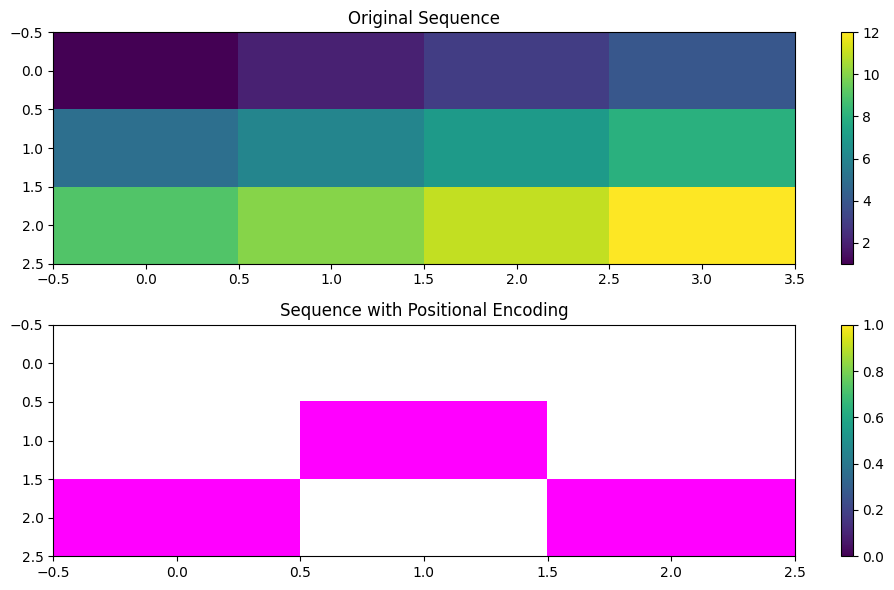

In [21]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=50):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Create a PositionalEncoding instance
pos_encoding = PositionalEncoding(d_model=4)

# Create a simple input sequence
input_sequence = torch.tensor([[1.0, 2.0, 3.0, 4.0],
                               [5.0, 6.0, 7.0, 8.0],
                               [9.0, 10.0, 11.0, 12.0]])

# Apply positional encoding
output_sequence = pos_encoding(input_sequence)

# Visualize the original and encoded sequences
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.title("Original Sequence")
plt.imshow(input_sequence.numpy(), cmap='viridis', aspect='auto')
plt.colorbar()

plt.subplot(2, 1, 2)
plt.title("Sequence with Positional Encoding")
plt.imshow(output_sequence.numpy(), cmap='viridis', aspect='auto')
plt.colorbar()

plt.tight_layout()
plt.show()


###2.2.4: Constructing the Transformer Model
#### This program uses a type of model called a "transformer."

####This model can be customized with some important settings:

####input_dim: This tells the model how many pieces of information it should consider as input. In this case, it's just one piece of information, which is the number of sunspots.
####d_model: This setting determines how much information the model can handle and remember. If it's big, the model can remember a lot, but it might need more computer power.
####nhead: Think of this as the number of "brains" the model has. The model can think in multiple ways at the same time, and this setting decides how many different thoughts it can have simultaneously.
####num_layers: It tells the model how many layers or steps it should use to understand the data. More layers mean it can think more deeply about the data.
####dropout: This is like a way to make the model more careful. It randomly forgets a bit of what it learned to avoid becoming too certain about things.
####In simple terms, this code creates a special computer program that's great at understanding time series data. You can change how it works by adjusting these settings. It's like giving the model different tools and abilities to handle different types of data.

In [24]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()#constructor

        self.encoder = nn.Linear(input_dim, d_model)#layer encoder transforms input_dim into d_model
        self.pos_encoder = PositionalEncoding(d_model, dropout)#instance of Positional encoding
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)#
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)#transform d_model into out of d = 1

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)#instantiation

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


input_sequence:
tensor([[ 0.0000],
        [ 0.0998],
        [ 0.1987],
        [ 0.2955],
        [ 0.3894],
        [ 0.4794],
        [ 0.5646],
        [ 0.6442],
        [ 0.7174],
        [ 0.7833],
        [ 0.8415],
        [ 0.8912],
        [ 0.9320],
        [ 0.9636],
        [ 0.9854],
        [ 0.9975],
        [ 0.9996],
        [ 0.9917],
        [ 0.9738],
        [ 0.9463],
        [ 0.9093],
        [ 0.8632],
        [ 0.8085],
        [ 0.7457],
        [ 0.6755],
        [ 0.5985],
        [ 0.5155],
        [ 0.4274],
        [ 0.3350],
        [ 0.2392],
        [ 0.1411],
        [ 0.0416],
        [-0.0584],
        [-0.1577],
        [-0.2555],
        [-0.3508],
        [-0.4425],
        [-0.5298],
        [-0.6119],
        [-0.6878],
        [-0.7568],
        [-0.8183],
        [-0.8716],
        [-0.9162],
        [-0.9516],
        [-0.9775],
        [-0.9937],
        [-0.9999],
        [-0.9962],
        [-0.9825],
        [-0.9589],
        [-0.925

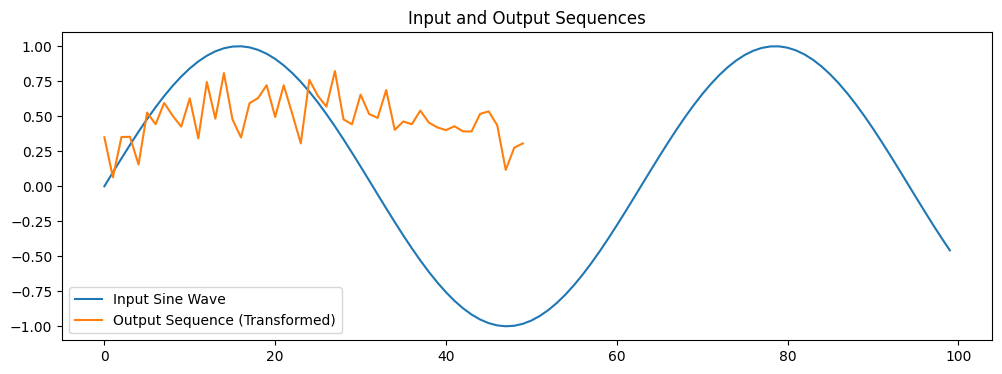

In [26]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)

# Function to generate a sine wave sequence
def generate_sine_wave(length, freq=0.1):
    t = np.arange(0, length, 1)
    return np.sin(freq * t)

# Generate a sine wave sequence
sequence_length = 100
sine_wave = generate_sine_wave(sequence_length)

# Convert the sine wave to a PyTorch tensor
input_sequence = torch.tensor(sine_wave, dtype=torch.float32).unsqueeze(1)

# Define and initialize the Transformer model
model = TransformerModel(input_dim=1, d_model=8, nhead=2, num_layers=2, dropout=0.1)

print(f'input_sequence:\n{input_sequence}')

# Print the model architecture
print(model)

# Forward pass through the model
output_sequence = model(input_sequence)

# Plot the input and output sequences
plt.figure(figsize=(12, 4))
plt.plot(sine_wave, label='Input Sine Wave')
plt.plot(output_sequence.detach().numpy(), label='Output Sequence (Transformed)')
plt.legend()
plt.title('Input and Output Sequences')
plt.show()


###Explanation:
####Input Sine Wave (Blue Line): This represents the original sine wave that you generated.
####Output Sequence (Transformed) (Orange Line): This is the output sequence generated by the Transformer model. The model takes the input sine wave sequence and processes it through its layers, including the positional encoding and the Transformer encoder. The orange line represents the model's prediction or transformation of the input sequence.


When we train a model, like this special transformer-based one, we follow some important rules and techniques that are similar to what we do with other computer models.

1. **Training in Batches**: We don't teach the model one example at a time. Instead, we group several examples together into batches. This is like teaching a bunch of students in a class rather than one student at a time. It makes the learning process faster and helps the model understand things better.

2. **Early Stopping**: Sometimes, when the model learns too much, it starts memorizing things instead of understanding them. So, we use a trick called "early stopping." We regularly check how well the model is doing on a separate set of data (we call it a validation set). If the model stops improving or gets too good at remembering the training data, we stop training. It's like saying, "You've learned enough."

3. **Validation Set**: This is like a practice test for the model. We use it to see how well the model is doing on data it has never seen before. It's important to make sure the model doesn't just learn to repeat the training data but can also handle new, unseen data.

In simple terms, while transformer models have some fancy tricks, the basic rules for training them are similar to other models. We use batches for efficient learning, stop training when the model is doing well, and check its performance on new data to make sure it's a smart learner.

In [27]:
# MPS acceleration is available on MacOS 12.3+,
#experiment with the latest PyTorch features and are running macOS 12.3 or later.


!pip install --pre torch torchvision torchaudio --index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://download.pytorch.org/whl/nightly/cpu


In [28]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:#set in [18] train_loader= 32
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)#move data to device

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)#differenxe between actual and predicted
        loss.backward()#The optimizer adjusts the model's parameters to reduce this loss (backpropagation).
        optimizer.step()

    # Validation
    model.eval()#model is set to evaluation mode
    val_losses = []
    with torch.no_grad():#disables gradient calculation bcs no updt on prmtr
        for batch in test_loader:#itr in valid dataset
            x_batch, y_batch = batch #extract inpt and targ label from batch introduced in line 10
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)#pass input to get prediction
            loss = criterion(outputs, y_batch)#calculate loss between predicted and actual
            val_losses.append(loss.item())#appnd to list and convert to float via item

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)#adjust lr based on val_loss

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1#there's no improvement

    if early_stop_count >= 5:# validation loss hasn't improved for 5 consecutive epochs,
    #                         and the training is not likely to improve further.
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

RuntimeError: ignored